<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/02_convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Convolutions

A convolution is "a mathematical operation on two functions (`f` and `g`) that produces a third function (`f * g`) expressing how the shape of one is modified by the other."

In image processing, a convolution matrix is also called a kernel or filter. 

Typical image processing operations—like blurring, sharpening, edge detection, and more, are
accomplished by performing a convolution between a kernel and an image.

##Setup

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [ ]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter5()
# This is needed to render the plots in this chapter
from plots.chapter5 import *

In [3]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Normalize

from data_generation.image_classification import generate_dataset
from helpers import index_splitter, make_balanced_sampler
from stepbystep.v1 import StepByStep

## Filter / Kernel

Usually, the filters are
small square matrices. The convolution itself is performed by applying the filter on
the image repeatedly. 

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/conv1.png?raw=1)

That’s the region to which the filter is being applied and is called the
receptive field, drawing an analogy to the way human vision works.

Let’s try a concrete example to make it more clear.

In [4]:
single = np.array([
  [ # batch dim
      [ # channel dim
          [5, 0, 8, 7, 8, 1], # height and width dim
          [1, 9, 5, 0, 7, 7],
          [6, 0, 2, 4, 6, 6],
          [9, 7, 6, 6, 8, 4],
          [8, 3, 8, 5, 1, 3],
          [7, 2, 7, 0, 1, 0]
      ]
  ]
])
single.shape

(1, 1, 6, 6)

In [5]:
identity = np.array([
    [
        [
            [0, 0, 0],
            [0, 1, 0],
            [0, 0, 0]
        ]
    ]
])
identity.shape

(1, 1, 3, 3)

##Convolving

Convulution performs an element-wise multiplication between the
two, region and filter, and adds everything up.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/conv2.png?raw=1)

In [6]:
region = single[:, :, 0:3, 0:3]
filtered_region = region * identity
total = filtered_region.sum()
total

9

Doing a convolution produces an image with a
reduced size.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/conv3.png?raw=1)

## Moving Around

Next, we move the region one step to the right; that is, we change the receptive
field and apply the filter again.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/stride1.png?raw=1)

In code, it means we’re changing the slice of the input image:

In [7]:
new_region = single[:, :, 0:3, (0+1):(3+1)]

But the operation remains the same: First, an element-wise multiplication, and
then adding up the elements of the resulting matrix.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/conv5.png?raw=1)

In [8]:
new_filtered_region = new_region * identity
new_total = new_filtered_region.sum()
new_total

5

Great! We have a second pixel value to add to our resulting image.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/conv6.png?raw=1)

We can keep moving the gray region to the right until we can’t move it anymore.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/conv7.png?raw=1)

The fourth step to the right will actually place the region partially outside the
input image.

In [9]:
last_horizontal_region = single[:, :, 0:3, (0+4):(3+4)]

The selected region does not match the shape of the filter anymore. 

So, if we try to
perform the element-wise multiplication, it fails:

In [10]:
try:
  last_horizontal_region * identity
except Exception as exp:
  print(exp)

operands could not be broadcast together with shapes (1,1,3,2) (1,1,3,3) 


##Shape

Next, we go back to the left side and move down one step. If we repeat the
operation, covering all valid regions, we’ll end up with a resulting image that is
smaller (on the right).

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/conv8.png?raw=1)

How much smaller is it going to be?

It depends on the size of the filter.

>The larger the filter, the smaller the resulting image.

Since applying a filter always produces a single value, the reduction is equal to the
filter size minus one.

$$
\Large
(h_i, w_i) * (h_f, w_f) = (h_i - (h_f - 1), w_i - (w_f - 1))
$$

If we assume the filter is a square matrix of size f, we can simplify the expression
above to:

$$
\Large
(h_i, w_i) * f = (h_i - f + 1, w_i - f + 1)
$$

But I’d like to keep the image size, is it possible?

Sure it is! Padding comes to our rescue in this case.

##Convolving in PyTorch

Now that we know how a convolution works, let’s try it out using PyTorch.

In [11]:
# convert our image and filter to tensors
image = torch.as_tensor(single).float()
kernel = torch.as_tensor(identity).float()

Just like the activation functions, convolutions come in two
flavors: functional and module. 

There is a fundamental difference between the
two, though: The functional convolution takes the kernel / filter as an argument
while the module has (learnable) weights to represent the kernel / filter.

Let’s use the functional convolution, `F.conv2d()`, to apply the identity filter to our
input image.

In [12]:
convolved = F.conv2d(image, kernel, stride=1)
convolved

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]])

Now, let’s turn our attention to PyTorch’s convolution module, `nn.Conv2d`.

In [13]:
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1)
conv(image)

tensor([[[[-2.9316, -0.0864,  0.8621, -0.2419],
          [ 0.5833,  0.5895, -2.6865, -0.9461],
          [-2.1605, -1.3302, -0.5297, -0.9163],
          [ 0.1566,  1.0850,  0.5501,  2.5671]]]],
       grad_fn=<ConvolutionBackward0>)

These results are gibberish now because the convolutional module randomly initializes the weights representing
the kernel / filter.

That’s the whole point of the convolutional module: It will learn
the kernel / filter on its own.

In traditional computer vision, people would develop different
filters for different purposes: blurring, sharpening, edge
detection, and so on.

Can we tell it to learn multiple filters at once?

In [14]:
conv_multiple = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1)
conv_multiple(image)

tensor([[[[-0.8032,  2.2359,  5.1481,  3.4676],
          [ 5.4154,  4.2610,  2.1250,  2.6113],
          [ 1.5885,  1.0453,  1.4714,  1.5167],
          [ 5.0344,  1.5347,  2.3275,  3.2528]],

         [[ 1.7809, -4.4379, -2.1811,  3.2840],
          [-1.0926,  2.8527,  3.5799,  1.4452],
          [ 2.4228,  2.2969,  0.9183, -1.2018],
          [-1.5256,  0.3706, -4.1544, -4.4124]]]],
       grad_fn=<ConvolutionBackward0>)

In [15]:
conv_multiple.weight

Parameter containing:
tensor([[[[ 0.1394,  0.3148,  0.0152],
          [ 0.0386, -0.2673,  0.0346],
          [ 0.0805,  0.0766,  0.1790]]],


        [[[-0.0703, -0.2870, -0.2112],
          [-0.3325,  0.2426,  0.1940],
          [ 0.1441,  0.2770,  0.2128]]]], requires_grad=True)

We can also force a convolutional module to use a particular filter by setting its weights.

In [16]:
with torch.no_grad():
  conv.weight[0] = kernel
  conv.bias[0] = 0

conv(image)

tensor([[[[9., 5., 0., 7.],
          [0., 2., 4., 6.],
          [7., 6., 6., 8.],
          [3., 8., 5., 1.]]]], grad_fn=<ConvolutionBackward0>)

In [17]:
conv.weight

Parameter containing:
tensor([[[[0., 0., 0.],
          [0., 1., 0.],
          [0., 0., 0.]]]], requires_grad=True)

Setting the weights to get specific filters is at the heart of
transfer learning. 

Someone else trained a model, and that model
learned lots of useful filters, so we don’t have to learn them
again. We can set the corresponding weights and go from there.

##Striding

Let’s try a stride of two for a change and see what happens to the resulting image.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/strider2.png?raw=1)

The resulting image, after the only four valid operations, looks like this.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/strider3.png?raw=1)

Also, notice that using a larger stride made the shape of the resulting image even smaller.

>The larger the stride, the smaller the resulting image.

Once again, it makes sense: If we are skipping pixels in the input image, there are
fewer regions of interest to apply the filter to. 

We can extend our previous formula
to include the stride size (s):

$$
\Large
(h_i, w_i) * f = \left(\frac{h_i - f + 1}{s}, \frac{w_i - f + 1}{s}\right)
$$

Let’s use
PyTorch’s functional convolution to double-check the results.

In [18]:
convolved_stride2 = F.conv2d(image, kernel, stride=2)
convolved_stride2

tensor([[[[9., 0.],
          [7., 6.]]]])

Cool, it works!

##Padding

So far, the operations we have performed have been shrinking the images. What
about restoring them to their original glory, I mean, size?

Padding means stuffing. We need to stuff the original image so it can sustain the "attack" on its size.

How do I stuff an image?

Simply add zeros around it.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/padding1.png?raw=1)

By adding columns and rows of zeros around it, we expand the
input image such that the gray region starts centered in the actual top left corner
of the input image. 

This simple trick can be used to preserve the original size of the
image.

In code, as usual, PyTorch gives us two options: functional (`F.pad()`) and module (`nn.ConstantPad2d`).

Let’s start with the module version this time:

In [19]:
constant_padder = nn.ConstantPad2d(padding=1, value=0)
constant_padder(image)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

One can also do asymmetric padding by specifying a tuple in the padding
argument representing (left, right, top, bottom). 

So, if we were to stuff our
image on the left and right sides only, the argument would go like this: `(1, 1, 0, 0)`.

We can achieve the same result using the functional padding:

In [20]:
padded = F.pad(image, pad=(1, 1, 1, 1), mode="constant", value=0)
padded

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 5., 0., 8., 7., 8., 1., 0.],
          [0., 1., 9., 5., 0., 7., 7., 0.],
          [0., 6., 0., 2., 4., 6., 6., 0.],
          [0., 9., 7., 6., 6., 8., 4., 0.],
          [0., 8., 3., 8., 5., 1., 3., 0.],
          [0., 7., 2., 7., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

Here, there is another argument, mode, which was
set to constant to match the module version above.

What are the other available modes?

There are three other modes: replicate, reflect, and circular.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/paddings.png?raw=1)

In replication padding, the padded pixels have the same value as the closest real
pixel.

In PyTorch, one can use the functional form `F.pad()` with mode="replicate", or use
the module version `nn.ReplicationPad2d`:

In [21]:
replication_padder = nn.ReplicationPad2d(padding=1)
replication_padder(image)

tensor([[[[5., 5., 0., 8., 7., 8., 1., 1.],
          [5., 5., 0., 8., 7., 8., 1., 1.],
          [1., 1., 9., 5., 0., 7., 7., 7.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [9., 9., 7., 6., 6., 8., 4., 4.],
          [8., 8., 3., 8., 5., 1., 3., 3.],
          [7., 7., 2., 7., 0., 1., 0., 0.],
          [7., 7., 2., 7., 0., 1., 0., 0.]]]])

In [22]:
padded = F.pad(image, pad=(1, 1, 1, 1), mode="replicate")
padded

tensor([[[[5., 5., 0., 8., 7., 8., 1., 1.],
          [5., 5., 0., 8., 7., 8., 1., 1.],
          [1., 1., 9., 5., 0., 7., 7., 7.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [9., 9., 7., 6., 6., 8., 4., 4.],
          [8., 8., 3., 8., 5., 1., 3., 3.],
          [7., 7., 2., 7., 0., 1., 0., 0.],
          [7., 7., 2., 7., 0., 1., 0., 0.]]]])

In reflection padding, it gets a bit trickier. It is like the outer columns and rows are
used as axes for the reflection.

In PyTorch, you can use the functional form `F.pad()` with mode="reflect", or use
the module version `nn.ReflectionPad2d`:

In [23]:
reflection_padder = nn.ReflectionPad2d(padding=1)
reflection_padder(image)

tensor([[[[9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 5., 0., 8., 7., 8., 1., 8.],
          [9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 6., 0., 2., 4., 6., 6., 6.],
          [7., 9., 7., 6., 6., 8., 4., 8.],
          [3., 8., 3., 8., 5., 1., 3., 1.],
          [2., 7., 2., 7., 0., 1., 0., 1.],
          [3., 8., 3., 8., 5., 1., 3., 1.]]]])

In [24]:
padded = F.pad(image, pad=(1, 1, 1, 1), mode="reflect")
padded

tensor([[[[9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 5., 0., 8., 7., 8., 1., 8.],
          [9., 1., 9., 5., 0., 7., 7., 7.],
          [0., 6., 0., 2., 4., 6., 6., 6.],
          [7., 9., 7., 6., 6., 8., 4., 8.],
          [3., 8., 3., 8., 5., 1., 3., 1.],
          [2., 7., 2., 7., 0., 1., 0., 1.],
          [3., 8., 3., 8., 5., 1., 3., 1.]]]])

In circular padding, the left-most (right-most) column gets copied as the right (left) padded column.

Similarly, the top-most
(bottom-most) row gets copied as the bottom (top) padded row. The corners
receive the values of the diametrically opposed corner.

In PyTorch, you must use the functional form `F.pad()` with mode="circular" since
there is no module version of the circular padding.

In [25]:
padded = F.pad(image, pad=(1, 1, 1, 1), mode="circular")
padded

tensor([[[[0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.],
          [7., 1., 9., 5., 0., 7., 7., 1.],
          [6., 6., 0., 2., 4., 6., 6., 6.],
          [4., 9., 7., 6., 6., 8., 4., 9.],
          [3., 8., 3., 8., 5., 1., 3., 8.],
          [0., 7., 2., 7., 0., 1., 0., 7.],
          [1., 5., 0., 8., 7., 8., 1., 5.]]]])

By padding an image, it is possible to get resulting images with the same shape as
input images, or even larger, should you choose to stuff more and more rows and
columns into the input image. 

Assuming we’re doing symmetrical padding of size p,
the resulting shape is given by the formula below:

$$
\Large
(h_i, w_i) * f = \left(\frac{(h_i + 2p) - f + 1}{s}, \frac{(w_i + 2p) - f + 1}{s}\right)
$$

We’re basically extending the original dimensions by 2p pixels each.

## A REAL Filter

Let’s try an edge detector filter from traditional
computer vision for a change:

In [26]:
edge_matrix = np.array([
  [[
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
  ]]
])

kernel_edge = torch.as_tensor(edge_matrix).float()
kernel_edge.shape

torch.Size([1, 1, 3, 3])

And let’s apply it to a different region of our (padded) input image.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/padding2.png?raw=1)

As you can see, filters, other than the identity one, do not simply copy the value at
the center. 

The element-wise multiplication finally means something.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/padding3.png?raw=1)

Let’s apply this filter to our image.

In [27]:
padded = F.pad(image, pad=(1, 1, 1, 1), mode="constant", value=0)
conv_padded = F.conv2d(padded, kernel_edge, stride=1)
conv_padded

tensor([[[[-19.,  22., -20., -12., -17.,  11.],
          [ 16., -30.,  -1.,  23.,  -7., -14.],
          [-14.,  24.,   7.,  -2.,   1.,  -7.],
          [-15., -10.,  -1.,  -1., -15.,   1.],
          [-13.,  13., -11.,  -5.,  13.,  -7.],
          [-18.,   9., -18.,  13.,  -3.,   4.]]]])

## Pooling

Pooling is different than the former operations: It splits the image into tiny chunks, performs an operation on each chunk (that yields a single value), and puts the chunks together as the resulting image.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/pooling1.png?raw=1)

Our input image is split into nine chunks, and we perform a simple max operation
(hence, max pooling) on each chunk (really, it is just taking the largest value in each
chunk). Then, these values are put together, in order, to produce a smaller
resulting image.

>The larger the pooling kernel, the smaller the resulting image.

In PyTorch, as usual, we have both forms: `F.max_pool2d()` and `nn.MaxPool2d`. 

Let’s
use the functional form to replicate the max pooling.

In [28]:
pooled = F.max_pool2d(conv_padded, kernel_size=2)
pooled

tensor([[[[22., 23., 11.],
          [24.,  7.,  1.],
          [13., 13., 13.]]]])

And then let’s use the module version to illustrate the large four-by-four pooling.

In [29]:
maxpool4 = nn.MaxPool2d(kernel_size=4)
pooled4 = maxpool4(conv_padded)
pooled4

tensor([[[[24.]]]])

Besides max pooling, average pooling is also fairly common. As the name
suggests, it will output the average pixel value for each chunk. 

In PyTorch, we have
`F.avg_pool2d()` and `nn.AvgPool2d`.

In [30]:
pooled = F.avg_pool2d(conv_padded, kernel_size=2)
pooled

tensor([[[[-2.7500, -2.5000, -6.7500],
          [-3.7500,  0.7500, -5.0000],
          [-2.2500, -5.2500,  1.7500]]]])

In [31]:
avgpool4 = nn.AvgPool2d(kernel_size=4)
pooled4 = avgpool4(conv_padded)
pooled4

tensor([[[[-2.0625]]]])

Can I use a stride of a different size?

In [32]:
pooled = F.max_pool2d(conv_padded, kernel_size=2, stride=1)
pooled

tensor([[[[22., 22., 23., 23., 11.],
          [24., 24., 23., 23.,  1.],
          [24., 24.,  7.,  1.,  1.],
          [13., 13., -1., 13., 13.],
          [13., 13., 13., 13., 13.]]]])

##Flattening

It simply flattens a tensor, preserving the first
dimension such that we keep the number of data points while collapsing all other
dimensions.

In [33]:
flattened = nn.Flatten()(pooled)
flattened

tensor([[22., 22., 23., 23., 11., 24., 24., 23., 23.,  1., 24., 24.,  7.,  1.,
          1., 13., 13., -1., 13., 13., 13., 13., 13., 13., 13.]])

We can also accomplish
the same thing using `view()`.

In [34]:
pooled.view(1, -1)

tensor([[22., 22., 23., 23., 11., 24., 24., 23., 23.,  1., 24., 24.,  7.,  1.,
          1., 13., 13., -1., 13., 13., 13., 13., 13., 13., 13.]])

##Typical Architecture

A typical architecture uses a sequence of one or more typical convolutional
blocks, with each block consisting of three operations:

1. Convolution
2. Activation function
3. Pooling

As images go through these operations, they will shrink in size.

After the sequence of blocks, the image gets flattened: Hopefully, at this stage,
there is no loss of information occurring by considering each value in the flattened
tensor a feature on its own.

If you think of it, what those typical convolutional blocks do is
akin to pre-processing images and converting them into
features.

###LeNet-5

LeNet-5 is a seven-level convolutional neural network developed by Yann LeCun in
1998 to recognize hand-written digits in 28x28 pixel images—the famous MNIST
dataset!

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/images/architecture_lenet.png?raw=1)

Adapting LeNet-5 to today’s standards, it could be implemented like this:

In [35]:
lenet = nn.Sequential()

###### Featurizer ##########
# Block 1: 1@28x28 -> 6@28x28 -> 6@14x14
lenet.add_module("C1", nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5, padding=2))
lenet.add_module("func1", nn.ReLU())
lenet.add_module("S2", nn.MaxPool2d(kernel_size=2))

# Block 2: 6@14x14 -> 16@10x10 -> 16@5x5
lenet.add_module("C3", nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5))
lenet.add_module("func2", nn.ReLU())
lenet.add_module("S4", nn.MaxPool2d(kernel_size=2))

# Block 3: 16@5x5 -> 120@1x1
lenet.add_module("C3", nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5))
lenet.add_module("func3", nn.ReLU())

# Flattening
lenet.add_module("flatten", nn.Flatten())

###### Classification ##########
# Hidden Layer
lenet.add_module("F6", nn.Linear(in_features=120, out_features=84))
lenet.add_module("func4", nn.ReLU())
# Output Layer
lenet.add_module("OUTPUT", nn.Linear(in_features=84, out_features=10))

LeNet-5 used three convolutional blocks, although the last one does not have a
max pooling, because the convolution already produces a single pixel.

Then, these 120 values (or features) are flattened and fed to a typical hidden layer
with 84 units. 

The last step is, obviously, the output layer, which produces ten
logits to be used for digit classification (from 0 to 9, there are ten classes).

##Multiclass Classification

A problem is considered a multiclass classification problem if there are more than
two classes. 

So, let’s keep it as simple as possible and build a model to classify
images into three classes.

###Data Generation

Our images are going to have either a diagonal or a parallel line, BUT this time we
will make a distinction between a diagonal line tilted to the right, a diagonal line
tilted to the left, and a parallel line like this.

| Line | Label/Class Index |
|---|---|
|Parallel (Horizontal OR Vertical)|0|
|Diagonal, Tilted to the Right|0|
|Diagonal, Tilted to the Left|1|


Also, let’s generate more and larger images: one thousand images, each one tenby-
ten pixels in size.


In [36]:
images, labels = generate_dataset(img_size=10, n_images=1000, binary=False, seed=17)

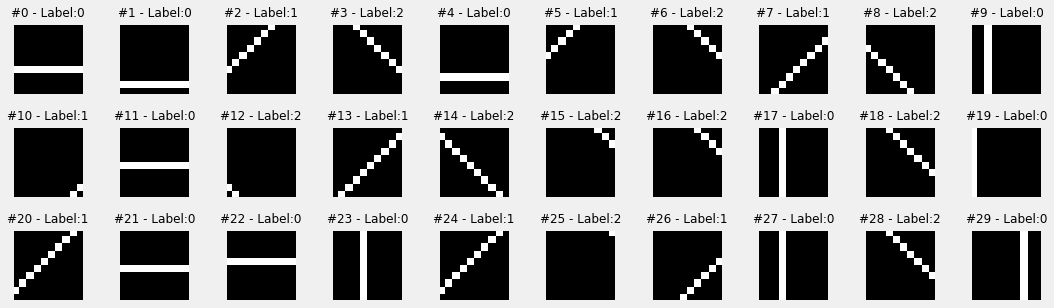

In [37]:
fig = plot_images(images, labels, n_plot=30)

###Data Preparation

In our particular problem, flipping an image has the potential to ruin the label.

So, we’re only keeping the min-max scaling by using the Normalize()
transform. All the rest remains the same: splitting, datasets, sampler, and data loaders.

In [38]:
class TransformedDataset(Dataset):
  def __init__(self, x, y, transform=None):
    self.x = x
    self.y = y
    self.transform = transform

  def __getitem__(self, index):
    x = self.x[index]

    # transforms the features
    if self.transform:
      x = self.transform(x)

    return x, self.y[index]

  def __len__(self):
    return len(self.x)

In [57]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels).long()

# Uses index_splitter to generate indices for training and validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
weighted_sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

###Loss

In binary classification problems, the model would produce one logit, and one logit
only, for each data point.

And we used a sigmoid function to map logits to probabilities. It was a
simple world :-)

But a multiclass classification is more complex:
that is, we need to get log odds ratios for every possible class. 

In other words, we
need as many logits as there are classes.

The softmax function returns, for each class, the contribution that a given class
had to the sum of odds ratios. The class with a higher odds ratio will have the
largest contribution and thus the highest probability.

Since the softmax is computed using odds ratios instead of log
odds ratios (logits), we need to exponentiate the logits!

$$
\Large
\begin{array}
& z & = \text{logit}(p) & = \text{log odds ratio }(p) & = \text{log}\left(\frac{p}{1-p}\right)
\\
e^z & = e^{\text{logit}(p)} & = \text{odds ratio }(p) & = \left(\frac{p}{1-p}\right)
\end{array}
$$

The softmax formula itself is quite simple:

$$
\Large
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{c=0}^{N_c-1}{e^{z_c}}}
$$

In our example, we have three classes, so our model
needs to output three logits $(z_0, z_1, z_2)$.

$$
\Large
\text{softmax}(z) = \left[\frac{e^{z_0}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_1}}{e^{z_0}+e^{z_1}+e^{z_2}},\frac{e^{z_2}}{e^{z_0}+e^{z_1}+e^{z_2}}\right]
$$

Simple, right? Let’s see it in code now.

In [40]:
logits = torch.tensor([1.3863, 0.0000, -0.6931])

# We exponentiate the logits to get the corresponding odds ratios
odds_ratios = torch.exp(logits)
odds_ratios

tensor([4.0000, 1.0000, 0.5000])

So we take these
odds and add them together, and then compute each class' contribution to the
sum:

In [41]:
softmaxed = odds_ratios / odds_ratios.sum()
softmaxed

tensor([0.7273, 0.1818, 0.0909])

Voilà! Our logits were softmaxed: The probabilities are proportional to the odds
ratios. 

This data point most likely belongs to the first class since it has a probability
of `72.73%`.

PyTorch
provides the typical implementations: functional (`F.softmax()`) and module
(`nn.Softmax`):

In [42]:
nn.Softmax(dim=-1)(logits)

tensor([0.7273, 0.1818, 0.0909])

In [43]:
F.softmax(logits, dim=-1)

tensor([0.7273, 0.1818, 0.0909])

In general, our models will produce logits with the shape (number of
data points, number of classes), so the right dimension to apply softmax to is the
last one (`dim=-1`).

###Negative Log Likelihood Loss

Since softmax returns probabilities, logsoftmax returns log probabilities. And
that’s the input for computing the negative log-likelihood loss, or `nn.NLLLoss()` for
short. 

This loss is simply an extension of the binary cross-entropy loss for handling
multiple classes.

This was the formula for computing binary cross-entropy:

$$
\Large
\texttt{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
$$

In our example, there are three
classes; that is, our `labels (y)` could be either zero, one, or two. 

So, the loss function
will look like this:

$$
\Large
\texttt{NLLLoss}(y)={-\frac{1}{(N_0+N_1+N_2)}\Bigg[{\sum_{i=1}^{N_0}{\text{log}(\text{P}(y_i=0))} + \sum_{i=1}^{N_1}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_2}{\text{log}(\text{P}(y_i=2))}}\Bigg]}
$$

The loss only considers the predicted probability for the true
class.

If a data point is labeled as belonging to class index two, the loss will consider the
probability assigned to class index two only. The other probabilities will be
completely ignored.

For a total of C classes, the formula can be written like this:

$$
\Large \texttt{NLLLoss}(y)={-\frac{1}{(N_0+\cdots+N_{C-1})}\sum_{c=0}^{C-1}{\sum_{i=1}^{N_c}{\text{log}(\text{P}(y_i=c))} }}
$$

Since the log probabilities are obtained by applying logsoftmax, this loss isn’t doing
much more than looking up the inputs corresponding to the true class and adding
them up.

In [44]:
log_probs = F.log_softmax(logits, dim=-1)
log_probs

tensor([-0.3185, -1.7048, -2.3979])

These are the log probabilities for each class we computed using logsoftmax for
our single data point. 

Now, let’s assume its label is two: What is the corresponding
loss?

In [45]:
label = torch.tensor([2])
F.nll_loss(log_probs.view(-1, 3), label)

tensor(2.3979)

It is the negative of the log probability corresponding to the class index (two) of the true label.

Let’s go through some quick examples.

In [46]:
torch.manual_seed(11)

dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])
dummy_log_probs = F.log_softmax(dummy_logits, dim=-1)
dummy_log_probs

tensor([[-1.5229, -0.3146, -2.9600],
        [-1.7934, -1.0044, -0.7607],
        [-1.2513, -1.0136, -1.0471],
        [-2.6799, -0.2219, -2.0367],
        [-1.0728, -1.9098, -0.6737]])

In [47]:
relevant_log_probs = torch.tensor([-1.5229, -1.7934, -1.0136, -2.0367, -1.9098])
- relevant_log_probs.mean()

tensor(1.6553)

Now, let’s use `nn.NLLLoss()` to create the actual loss function, and then use
predictions and labels to check if we got the relevant log probabilities right:

In [48]:
loss_fn = nn.NLLLoss()
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.6553)

What if we want to balance our dataset, giving data points with label
(y=2) double the weight of the other classes?

In [49]:
loss_fn = nn.NLLLoss(weight=torch.tensor([1., 1., 2.]))
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.7188)

And what if we want to simply ignore data points with label (y=2)?

In [50]:
loss_fn = nn.NLLLoss(ignore_index=2)
loss_fn(dummy_log_probs, dummy_labels)

tensor(1.5599)

And, once again, there is yet another loss function available for multiclass
classification. 

And, once again, it is very important to know when to use one or the
other.

So you don’t end up with an inconsistent combination of model and loss
function.

###Cross-Entropy Loss

This loss function combines both the logsoftmax layer and
the negative log-likelihood loss into one.

But you must use the right
combination of model and loss function!

- **Option 1**: nn.LogSoftmax as the last layer, meaning your model is
producing log probabilities, combined with the `nn.NLLLoss()`
function.
- **Option 2**: No logsoftmax in the last layer, meaning your model is
producing logits, combined with the `nn.CrossEntropyLoss()`
function.

Mixing `nn.LogSoftmax` and `nn.CrossEntropyLoss()` is just wrong.

Let’s see a quick example of its usage.

In [51]:
torch.manual_seed(11)

dummy_logits = torch.randn((5, 3))
dummy_labels = torch.tensor([0, 0, 1, 2, 1])

loss_fn = nn.CrossEntropyLoss()
loss_fn(dummy_logits, dummy_labels)

tensor(1.6553)

No logsoftmax whatsoever, but the same resulting loss, as expected.

##Convolutional neural network

Let’s build our first convolutional neural network for real! 

We can use the typical
convolutional block: convolutional layer, activation function, pooling layer. 

Our images are quite small, so we only need one of those.

In [52]:
torch.manual_seed(13)

cnn_model = nn.Sequential()

##### Featurizer #######
# Block 1: 1@10x10 -> n_channels@8x8 -> n_channels@4x4
n_channels = 1
cnn_model.add_module("conv1", nn.Conv2d(in_channels=1, out_channels=n_channels, kernel_size=3))
cnn_model.add_module("relu1", nn.ReLU())
cnn_model.add_module("maxp1", nn.MaxPool2d(kernel_size=2))

# Flattening: n_channels * 4 * 4
cnn_model.add_module("flatten", nn.Flatten())

###### Classification ######
# Hidden Layer
cnn_model.add_module("fc1", nn.Linear(in_features=n_channels * 4 * 4, out_features=10))
cnn_model.add_module("relu2", nn.ReLU())
# Output Layer
cnn_model.add_module("fc2", nn.Linear(in_features=10, out_features=3))

Since our model produces logits, we must use the `nn.CrossEntropyLoss()`.

In [53]:
lr = 0.1
loss_fn = nn.CrossEntropyLoss(reduction="mean")
optimizer = optim.SGD(cnn_model.parameters(), lr=lr)

Let's train the model.

In [59]:
sbs_cnn1 = StepByStep(cnn_model, loss_fn, optimizer)
sbs_cnn1.set_loaders(train_loader, val_loader)

In [60]:
sbs_cnn1.train(20)

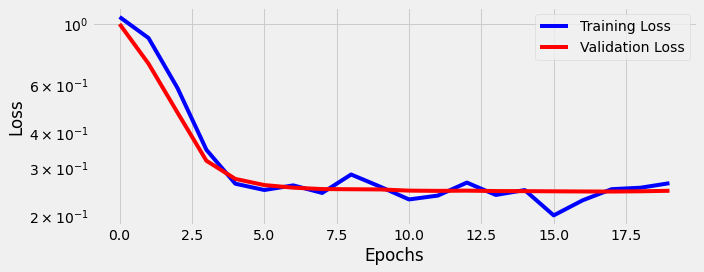

In [61]:
fig = sbs_cnn1.plot_losses()

##Visualizing Filters